# Fine Tuning Roberta





In [ ]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.0 MB/s eta 0:00:00


In [ ]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
#device = 'cpu'

### Importing the data

In [ ]:
train = pd.read_excel('/content/Train_set.xlsx')
validation = pd.read_excel("/content/Validation_set.xlsx")
test = pd.read_excel("/content/Test_set.xlsx")

In [ ]:
train.shape

(3153, 3)

In [ ]:
train.head()

,COMENTARIOS,Categorización,Comentarios_limpios
0,Para pasar esta clase se necesita además del f...,MIXTO,pasar clase necesita ademas foro escribir refe...
1,Me gustaría que nos de cuestionarios tipo exám...,MIXTO,gustaria cuestionarios tipo examen examenes pr...
2,Incluir actividades grupales o más interactiva...,MIXTO,incluir actividades grupales interactivas proc...
3,considero que falto un poco de ayuda de su par...,MIXTO,considero falto ayuda parte poder enterder bie...
4,Juan es un tanto desorganizado respecto a como...,MIXTO,juan desorganizado respecto imparte clases hab...


In [ ]:
train = train[['Categorización','Comentarios_limpios']]
validation = validation[['Categorización','Comentarios_limpios']]
test = test[['Categorización','Comentarios_limpios']]

# Converting the codes to appropriate categories using a dictionary
my_dict = {
    'MALO':'negative',
    'MIXTO':'neutral',
    'BUENO':'positive'
}

def update_cat(x):
    return my_dict[x]

train['CATEGORY'] = train['Categorización'].apply(lambda x: update_cat(x))
validation['CATEGORY'] = validation['Categorización'].apply(lambda x: update_cat(x))
test['CATEGORY'] = test['Categorización'].apply(lambda x: update_cat(x))

encode_dict = {}

def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

train['Sentiment'] = train['CATEGORY'].apply(lambda x: encode_cat(x))
train = train.rename(columns = {"Comentarios_limpios":"Phrase"})

validation['Sentiment'] = validation['CATEGORY'].apply(lambda x: encode_cat(x))
validation = validation.rename(columns = {"Comentarios_limpios":"Phrase"})

test['Sentiment'] = test['CATEGORY'].apply(lambda x: encode_cat(x))
test = test.rename(columns = {"Comentarios_limpios":"Phrase"})

In [ ]:
new_train = train[['Phrase', 'Sentiment']]
new_validation = validation[['Phrase', 'Sentiment']]
new_test = test[['Phrase', 'Sentiment']]

### Preparing the Dataset and Dataloader


In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
TEST_BATCH_SIZE = 4
EPOCHS = 4
LEARNING_RATE = 2e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Phrase
        self.targets = self.data.Sentiment
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_data= new_train.reset_index(drop=True)
valid_data = new_validation.reset_index(drop=True)
test_data = new_test.reset_index(drop=True)


print("TRAIN Dataset: {}".format(train_data.shape))
print("VALIDATION Dataset: {}".format(valid_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
validation_set = SentimentData(valid_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

TRAIN Dataset: (3153, 2)
VALIDATION Dataset: (1050, 2)
TEST Dataset: (1053, 2)


In [ ]:
test_data

,Phrase,Sentiment
0,profe explico temas asertividad embargo pienso...,0
1,buen profe domina tema existe pequena dificult...,0
2,buen profesor embargo considero flexibilidad i...,0
3,parece metodologia usada jose personal permiti...,0
4,requiere mejor explicacion informes seminarios...,0
...,...,...
1048,buena clase,2
1049,genial maestro juan amplio conocimiento junto ...,2
1050,jose ayudo volver despertar interes cientifico,2
1051,excelente apertura estudiantes metodologia apr...,2


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **valid_params)
testing_loader = DataLoader(testing_set, **test_params)

### Creating the Neural Network for Fine Tuning


In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = RobertaClass()
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

### Fine Tuning the Model


In [ ]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model
lista_acc_train = []
lista_loss_train = []
best_accuracy_train = 0

def train(epoch):
    global best_accuracy_train, predictions_final_train, targets_list_final_train
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    predictions_train = []
    targets_list_train = []
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        targets_list_train.extend(targets.cpu().numpy())

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        predictions_train.extend(predicted.cpu().numpy())

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")
    lista_acc_train.append(epoch_accu)
    lista_loss_train.append(epoch_loss)

    if best_accuracy_train < epoch_accu:
      predictions_final_train = predictions_train
      targets_list_final_train = targets_list_train

    best_accuracy_train = epoch_accu


    return lista_acc_train, lista_loss_train, predictions_final_train, targets_list_final_train

### Validating the Model


In [ ]:
lista_loss_valid = []
lista_acc_valid = []
best_accuracy = 0

def valid(model, validation_loader):
    global best_accuracy, predictions_final_valid, targets_list_final_valid
    model.eval()
    n_correct = 0
    n_wrong = 0
    total = 0
    tr_loss = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    predictions = []
    targets_list = []
    a = []

    with torch.no_grad():
        for _, data in tqdm(enumerate(validation_loader, 0)):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)
            outputs = model(ids, mask, token_type_ids).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)
            targets_list.extend(targets.cpu().numpy())
            a.extend(big_idx)

            nb_tr_steps += 1
            nb_tr_examples += targets.size(0)

            if _ % 5000 == 0:
                loss_step = tr_loss / nb_tr_steps
                accu_step = (n_correct * 100) / nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")

            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())


    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) / nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    lista_acc_valid.append(epoch_accu)
    lista_loss_valid.append(epoch_loss)

    if best_accuracy < epoch_accu:

      predictions_final_valid = predictions
      targets_list_final_valid = targets_list

    best_accuracy = epoch_accu

    return epoch_accu, predictions_final_valid, targets_list_final_valid, lista_acc_valid, lista_loss_valid


In [ ]:
lista_acc_train = []
lista_loss_train = []
lista_loss_valid = []
lista_acc_valid = []
best_accuracy_train = 0
best_accuracy = 0
predictions_final_valid = []  # Initialize predictions_final_valid outside the loop
targets_list_final_valid = []

for epoch in range(EPOCHS):
    y_train_acc, y_train_loss, preds_train, targets_train = train(epoch)
    acc, preds_valid, targets_valid, y_valid_acc, y_valid_loss = valid(model, validation_loader)
    print("Accuracy on test data = %0.2f%%" % acc)


0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
1it [00:03,  3.21s/it]

Training Loss per 5000 steps: 1.1744495630264282
Training Accuracy per 5000 steps: 37.5


395it [00:55,  7.12it/s]


The Total Accuracy for Epoch 0: 47.82746590548684
Training Loss Epoch: 0.9624042507968371
Training Accuracy Epoch: 47.82746590548684


8it [00:00, 72.97it/s]

Validation Loss per 100 steps: 0.6735603213310242
Validation Accuracy per 100 steps: 50.0


525it [00:09, 55.92it/s]


Validation Loss Epoch: 0.8381785330602101
Validation Accuracy Epoch: 55.61904761904762
Accuracy on test data = 55.62%


1it [00:00,  8.23it/s]

Training Loss per 5000 steps: 0.773399829864502
Training Accuracy per 5000 steps: 87.5


395it [00:50,  7.86it/s]


The Total Accuracy for Epoch 1: 61.3384078655249
Training Loss Epoch: 0.7716189074506865
Training Accuracy Epoch: 61.3384078655249


5it [00:00, 49.08it/s]

Validation Loss per 100 steps: 1.429248571395874
Validation Accuracy per 100 steps: 50.0


525it [00:08, 63.64it/s]


Validation Loss Epoch: 0.7035797719799337
Validation Accuracy Epoch: 69.61904761904762
Accuracy on test data = 69.62%


1it [00:00,  8.24it/s]

Training Loss per 5000 steps: 0.7978088855743408
Training Accuracy per 5000 steps: 62.5


395it [00:50,  7.79it/s]


The Total Accuracy for Epoch 2: 73.0732635585157
Training Loss Epoch: 0.612420788926037
Training Accuracy Epoch: 73.0732635585157


5it [00:00, 44.32it/s]

Validation Loss per 100 steps: 0.3647465407848358
Validation Accuracy per 100 steps: 100.0


525it [00:07, 69.08it/s]


Validation Loss Epoch: 0.6108098472069416
Validation Accuracy Epoch: 73.71428571428571
Accuracy on test data = 73.71%


1it [00:00,  8.07it/s]

Training Loss per 5000 steps: 0.6556532979011536
Training Accuracy per 5000 steps: 62.5


395it [00:50,  7.75it/s]


The Total Accuracy for Epoch 3: 79.06755470980019
Training Loss Epoch: 0.4966613371726833
Training Accuracy Epoch: 79.06755470980019


7it [00:00, 62.71it/s]

Validation Loss per 100 steps: 0.6417542695999146
Validation Accuracy per 100 steps: 50.0


525it [00:07, 66.03it/s]


Validation Loss Epoch: 0.6092957296435322
Validation Accuracy Epoch: 74.0
Accuracy on test data = 74.00%


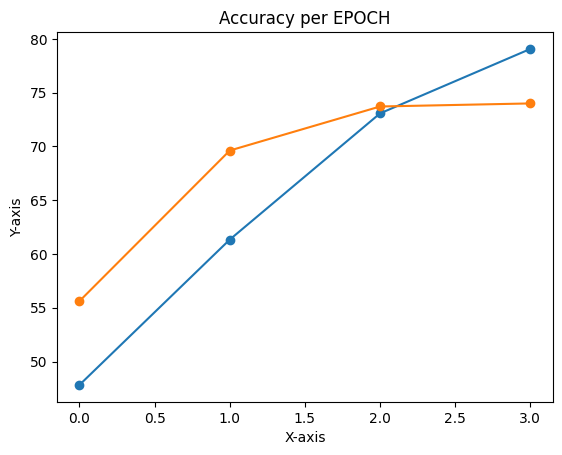

In [ ]:
import matplotlib.pyplot as plt

# Sample data

x_acc = []

for i in range(EPOCHS):
  x_acc.append(i)

# Create the line plot
plt.plot(x_acc, y_train_acc, marker='o')
plt.plot(x_acc, y_valid_acc, marker='o')

# Add title and labels
plt.title('Accuracy per EPOCH')
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')

# Display the plot
plt.show()

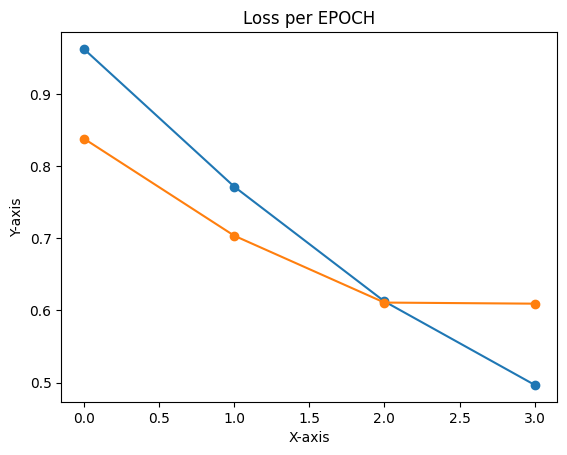

In [ ]:
x_loss = []

for i in range(EPOCHS):
  x_loss.append(i)

# Create the line plot
plt.plot(x_loss, y_train_loss, marker='o')
plt.plot(x_loss, y_valid_loss, marker='o')

# Add title and labels
plt.title('Loss per EPOCH')
plt.xlabel('EPOCH')
plt.ylabel('Loss')

# Display the plot
plt.show()

## Confusion Matrix

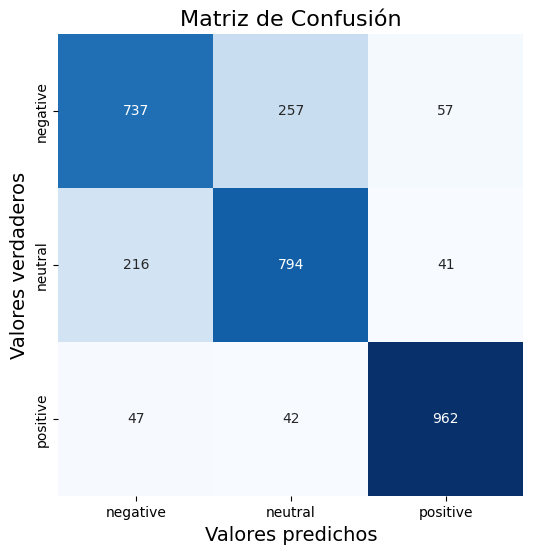

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Train


label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
predicted_labels = [label_mapping[val] for val in preds_train]
labels_graph = ["negative", "neutral", "positive"]

labels = test_data["Sentiment"]
labels_1 = [label_mapping[val] for val in targets_train]
cm = confusion_matrix(labels_1, predicted_labels, labels = labels_graph)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels_graph,
                yticklabels=labels_graph)
plt.xlabel('Valores predichos', fontsize=14)
plt.ylabel('Valores verdaderos', fontsize=14)
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

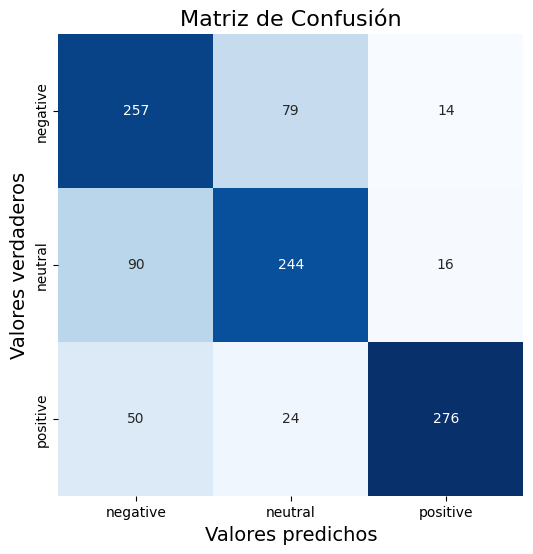

In [ ]:
label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
predicted_labels = [label_mapping[val] for val in preds_valid]
labels_graph = ["negative", "neutral", "positive"]

labels = test_data["Sentiment"]
labels_1 = [label_mapping[val] for val in targets_valid]
cm = confusion_matrix(labels_1, predicted_labels, labels = labels_graph)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels_graph,
                yticklabels=labels_graph)
plt.xlabel('Valores predichos', fontsize=14)
plt.ylabel('Valores verdaderos', fontsize=14)
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

### Testing the model

In [ ]:
lista_loss_valid = []
lista_acc_valid = []
best_accuracy = 0
predictions_final_valid = []  # Initialize predictions_final_valid outside the loop
targets_list_final_valid = []

acc, preds_test, targets_test, y_test_acc, y_test_loss = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
6it [00:00, 52.82it/s]

Validation Loss per 100 steps: 0.15127001702785492
Validation Accuracy per 100 steps: 100.0


351it [00:07, 49.76it/s]

Validation Loss Epoch: 0.6272092487588737
Validation Accuracy Epoch: 73.78917378917379
Accuracy on test data = 73.79%


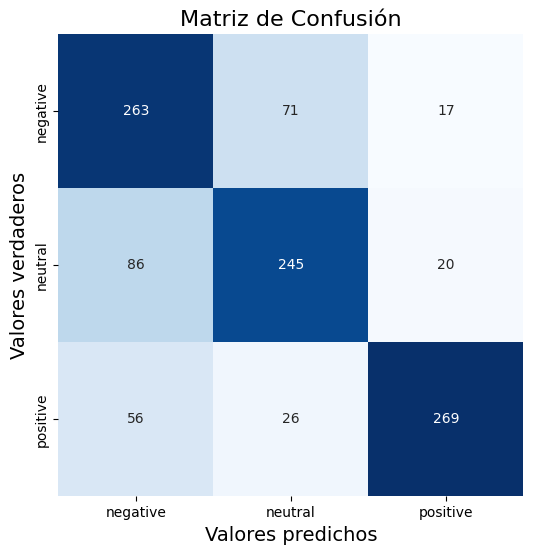

In [ ]:
label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
predicted_labels = [label_mapping[val] for val in preds_test]
labels_graph = ["negative", "neutral", "positive"]

labels = test_data["Sentiment"]
labels_1 = [label_mapping[val] for val in targets_test]
cm = confusion_matrix(labels_1, predicted_labels, labels = labels_graph)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels_graph,
                yticklabels=labels_graph)
plt.xlabel('Valores predichos', fontsize=14)
plt.ylabel('Valores verdaderos', fontsize=14)
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

### Saving the Trained Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
output_model_file = '/content/drive/MyDrive/Tesis/Jose/pytorch_roberta_sentiment.bin'
output_vocab_file = './'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')
print('This tutorial is completed')

All files saved
This tutorial is completed
